In [26]:
import numpy as np
import scipy.special as sp
import matplotlib.pyplot as plt

In [73]:
def mean(p, N):                         # Mean value of successes E(n)
    return p*N

def var(p, N):                          # Variance of successes V(n)
    return p*N*(1-p)

def sigma(p, N):
    return np.sqrt(var(p,N))/N                 

def Z(CL):
    return np.sqrt(2)*sp.erfinv(CL)     # Function that returns the number of sigmas for a given CL

def wald(n, N, CL, verbose=False):
    p_hat = n/N                         # Estimation of p as p = n / N = #successes / #experiments
    p_sigma = sigma(p_hat,N)            # Standard deviation of p
    z = Z(CL)
    interval = [p_hat - z*p_sigma, p_hat + z*p_sigma]  # Confidence interval for p in the Gaussian approximation
    if(verbose == True):
        print("The Wald confidence interval for p given %d successes in %d experiments is:" % (n, N) )
        print(interval)
    return interval

def wilson(n, N, CL, verbose=False):   
    p_hat = n/N
    p_sigma = sigma(p_hat,N)
    z = Z(CL)
    step = 0.01
    p1 = p_hat                           #initialise
    p2 = p_hat                           #initialise
    while(p1 + z*sigma(p1,N) >= p_hat):
        p1-=step
    while(p_hat >= p2 - z*sigma(p2,N)):
        p2+=step
    interval = [p1, p2]  # Wilson confidence interval for p
    if(verbose == True):
        print("The Wilson confidence interval for p given %d successes in %d experiments is:" % (n, N) )
        print(interval)
    return interval

def agresticoull(n,N,CL,verbose=False):
    int_wilson = wilson(n,N,CL)
    p_midpoint_wilson = (int_wilson[0]+int_wilson[1])/2
    p_sigma = sigma(p_midpoint_wilson,N) 
    z = Z(CL)
    interval = [p_midpoint_wilson - z*p_sigma, p_midpoint_wilson + z*p_sigma]  # Confidence interval for p in the Gaussian approximation
    if(verbose == True):
        print("The Agresti and Coull confidence interval for p given %d successes in %d experiments is:" % (n, N) )
        print(interval)
    return interval
    

        

In [103]:
N = 10
n = 9
CL = 0.6827
z = Z(CL)

wald(n, N, CL, verbose=True)
wilson(n,N,CL, verbose=True)
agresticoull(n,N,CL, verbose=True)

The Wald confidence interval for p given 9 successes in 10 experiments is:
[0.8051296102882612, 0.9948703897117388]
The Wilson confidence interval for p given 9 successes in 10 experiments is:
[0.7599999999999999, 0.9700000000000001]
The Agresti and Coull confidence interval for p given 9 successes in 10 experiments is:
[0.7569351716784586, 0.9730648283215414]


[0.7569351716784586, 0.9730648283215414]

/home/pipsini/Programs/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in sqrt
  


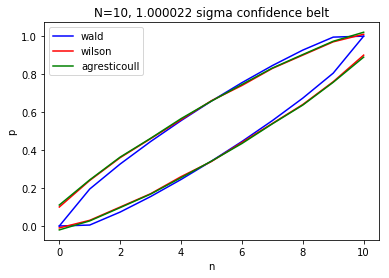

In [104]:
#prepare empty lists for the upper and lower limits for the three intervals
lower_wald = []
upper_wald = []
lower_wilson = []
upper_wilson = []
lower_agresticoull = []
upper_agresticoull = []

#n can range from 0 to N included
n_range = range(0,N+1)

for n in n_range:
    #wald limits
    lower_wald.append(wald(n,N,CL)[0])
    upper_wald.append(wald(n,N,CL)[1])
    #wilson limits
    lower_wilson.append(wilson(n,N,CL)[0])
    upper_wilson.append(wilson(n,N,CL)[1])
    #agresti and coull limits
    lower_agresticoull.append(agresticoull(n,N,CL)[0])
    upper_agresticoull.append(agresticoull(n,N,CL)[1])
    
#plot limits.. confidence belt?
plt.plot(n_range,lower_wald,label="wald", color='b')
plt.plot(n_range,upper_wald, color='b')
plt.plot(n_range,lower_wilson,label="wilson", color='r')
plt.plot(n_range,upper_wilson, color='r')
plt.plot(n_range,lower_agresticoull,label="agresticoull", color='g')
plt.plot(n_range,upper_agresticoull, color='g')
plt.xlabel("n")
plt.ylabel("p")
plt.title("N=%d, %f sigma confidence belt"% (n,z))

plt.legend(loc='best')
